# Clustering & Self-Supervised Learning (Image)

### As mentioned above, you are given an image and a text dataset. The image dataset has 10 true classes. The text dataset has 5 true classes. Your job is twofold:
● First, create labels for the unlabelled datasets by creating appropriate embedding /encoding for the entries in the dataset. Then, use a clustering algorithm of your choice to create clusters. Once the clusters are created, you can use the clusters to assign labels to each example in the dataset. We will call the dataset given to you as X_train and the labels that you have generated as Y_train.

● Second, use {X_train, Y_train} to train a classifier of your choice

In [282]:
# Imports
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report

In [284]:
# Load Dataset
try:
    dataset = np.load('sample_data/unlabelled_train_data_images.npy', allow_pickle=True)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {dataset.shape}")
    print(f"Dataset size: {dataset.size}")
except FileNotFoundError:
    print("Error: 'unlabelled_train_data_images.npy' not found in 'sample_data' folder.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Dataset loaded successfully.
Dataset shape: (60000, 1, 28, 28)
Dataset size: 47040000


In [285]:
# Check for blank images
blank_imgs = [i for i in range(len(dataset)) if np.std(dataset[i]) < 1e-3]
print(f"Number of nearly blank images: {len(blank_imgs)}")


Number of nearly blank images: 0


### Key Observation
---

#### No blank images


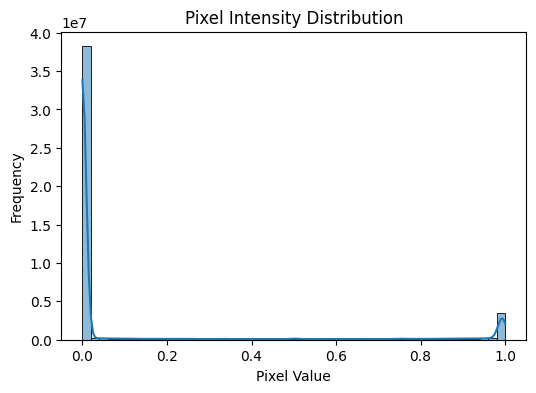

In [260]:
# Pixel intensity distribution
flat_pixels = dataset.reshape(-1)
plt.figure(figsize=(6, 4))
sns.histplot(flat_pixels, bins=50, kde=True)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


### Key Observation
---
#### Very high spike near 0:

Most pixel values are close to 0, meaning the images are predominantly dark.
This could be because the background of the images is black, and only small regions (e.g. digits or strokes) have brighter pixels.

#### Small peak near 1:

A smaller, sharp rise near pixel value 1 indicates that a subset of pixels is fully white (value = 1).This is typical in datasets like MNIST, where digit strokes are white on a black background.

#### Very few mid-range values (0.1 to 0.9):

Suggests that most images are binary-like, with sharp contrast — either black (0) or white (1), and very few gray shades.Indicates low grayscale complexity — images are likely sparse and have high contrast outlines

In [286]:
print("Image shape consistency:", all([img.shape == (28, 28) for img in dataset])) # Check shape of images in dataset are 28x28

Image shape consistency: False


### Key Observation
---
- Not all images in the dataset have shape (28 x 28)

In [287]:
# Counter to  understand the  image shape distribution
from collections import Counter

shapes = [img.shape for img in dataset]
shape_counts = Counter(shapes)
print("Image shape distribution:", shape_counts)


Image shape distribution: Counter({(1, 28, 28): 60000})


In [288]:
# remove that extra channel dimension once and for all
if dataset.ndim == 4 and dataset.shape[1] == 1:
    dataset = dataset.squeeze(1)   # now X.shape == (n_samples, 28, 28)
print("Total number of images Size of dataset:", dataset.shape[0])
print("Size of image:", dataset.shape)

Total number of images Size of dataset: 60000
Size of image: (60000, 28, 28)


In [289]:
print("Image shape consistency:", all([img.shape == (28, 28) for img in dataset]))

Image shape consistency: True


### Key Observation
---
- All images in the dataset have shape (28 x 28) now

# Image Transformation

*   Deskew
*   Center



In [306]:
# --- Load your MNIST dataset (assumed to be in X) ---
X = dataset[:5000]  # Use first 5000 images to iterate faster: Original subset of images from dataset
X = np.array([preprocess_image(img) for img in X])  # Shape: (5000, 28, 28)

In [291]:
import cv2

def deskew(img):
    # Compute image moments
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img  # already roughly straight
    # Estimate skew and build transform
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5*img.shape[1]*skew],
                    [0,     1,                   0]])
    return cv2.warpAffine(img, M, img.shape[::-1],
                          flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)

def center(img):
    # Shift the digit so its center of mass is image center
    m = cv2.moments(img)
    if m['m00'] != 0:
        cx, cy = m['m10']/m['m00'], m['m01']/m['m00']
        tx = int(img.shape[1]/2 - cx)
        ty = int(img.shape[0]/2 - cy)
        M = np.float32([[1,0,tx],[0,1,ty]])
        return cv2.warpAffine(img, M, img.shape[::-1])
    return img

In [292]:
def preprocess_image(img):
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    img = deskew(img)
    img = center(img)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist((img*255).astype(np.uint8))

    return img

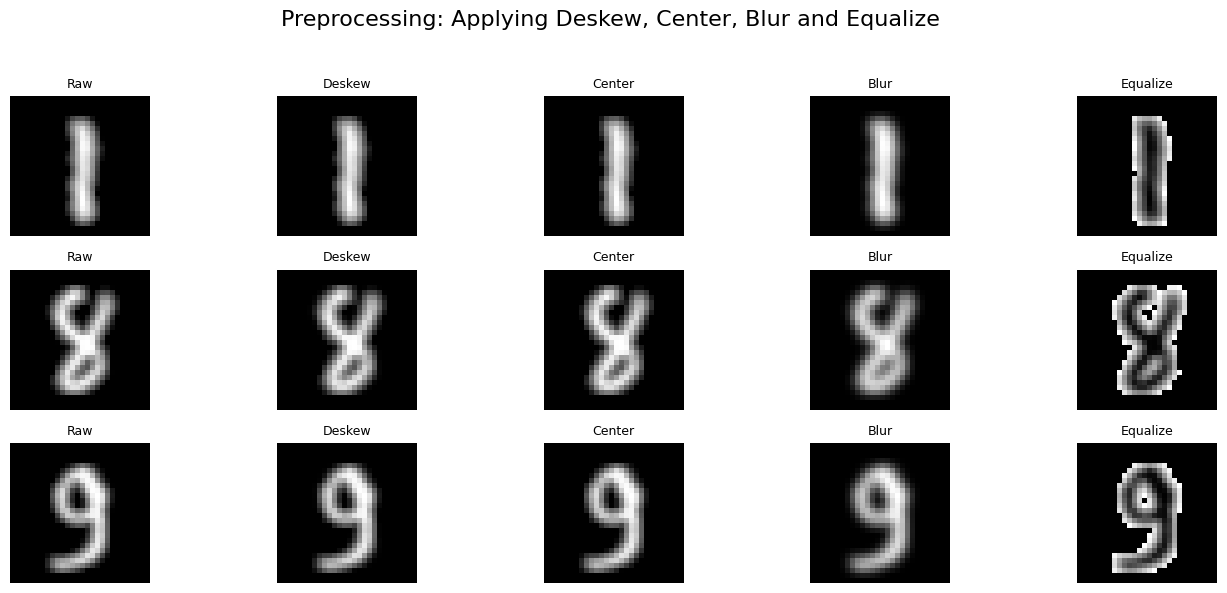

In [293]:
import numpy as np

# Pick 3 random indices
idxs = np.random.choice(len(X), 3, replace=False)
steps = [
    ("Raw",     lambda im: im),
    ("Deskew",  deskew),
    ("Center",  center),
    ("Blur",    lambda im: cv2.GaussianBlur(im, (3,3), 0)),
    ("Equalize",lambda im: cv2.equalizeHist((im*255).astype(np.uint8)))
]

fig, axes = plt.subplots(len(idxs), len(steps), figsize=(14,6))
for i, idx in enumerate(idxs):
    base = (X[idx]*255).astype(np.uint8)
    for j, (title, fn) in enumerate(steps):
        out = fn(base)
        axes[i,j].imshow(out, cmap='gray')
        axes[i,j].set_title(title, fontsize=9)
        axes[i,j].axis('off')
plt.suptitle("Preprocessing: Applying Deskew, Center, Blur and Equalize ", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [294]:
def print_pca_variance(pca):
    print("\n🔍 PCA Explained Variance:")
    for i, ratio in enumerate(pca.explained_variance_ratio_[:10]):
        print(f"Component {i+1}: {ratio:.4f}")

In [295]:
# --- Dimensionality Reduction ---
def reduce_dimensionality(X, n_components=50):
    X_flat = X.reshape(X.shape[0], -1)  # shape: (n_samples, 784)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_flat)

    # Diagnostic prints
    print("Original shape:", X.shape)
    print("Flattened shape:", X_flat.shape)
    print("PCA output shape:", X_pca.shape)

    return X_pca, pca, X_flat

In [296]:
def silhouette_score_analysis(X, min_k=2, max_k=12, plot=True):
    ks = list(range(min_k, max_k + 1))
    scores = []

    for k in ks:
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(ks, scores, marker='o', linestyle='-')
        plt.title("Silhouette Score vs. Number of Clusters")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Silhouette score")
        plt.xticks(ks)
        plt.grid(alpha=0.3)
        plt.show()

    best_k = ks[scores.index(max(scores))]
    print(f"✅ Optimal number of clusters by silhouette analysis: k = {best_k}")
    return best_k

In [297]:
# --- Clustering ---
def apply_kmeans(X_pca, use_silhouette_score=True, labels=None):
    if use_silhouette_score:
        best_k = silhouette_score_analysis(X_pca, plot=False)
    else:
        best_k = 10

    kmeans = KMeans(n_clusters=best_k, random_state=42)
    y_cluster = kmeans.fit_predict(X_pca)
    return y_cluster, kmeans

In [298]:
def print_precision_recall_f1(y_true, y_pred, model_name="Model"):
    print(f"\n📊 Precision, Recall, and F1-score for {model_name}:")
    print(classification_report(y_true, y_pred, digits=4))

In [299]:
# --- Random Forest Classification ---
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc, y_test, y_pred

In [300]:
# --- t-SNE Visualization ---
def plot_tsne(X, labels, title="t-SNE Visualization"):
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.colorbar(scatter)
    plt.grid(alpha=0.3)
    plt.show()

In [301]:
# Plot 10 random images from a cluster and plot them
def plot_random_images_from_clusters(X, labels, num_images_per_cluster=10):
    unique_labels = np.unique(labels)
    print(f"\n🖼️ Displaying {num_images_per_cluster} random images from each of {len(unique_labels)} clusters:")

    plt.figure(figsize=(2 * num_images_per_cluster, 2 * len(unique_labels)))

    for i, cluster_label in enumerate(unique_labels):
        # Get indices of images belonging to the current cluster
        cluster_indices = np.where(labels == cluster_label)[0]
        # Randomly sample indices from this cluster
        sampled_indices = np.random.choice(cluster_indices, min(num_images_per_cluster, len(cluster_indices)), replace=False)

        print(f"Cluster {cluster_label} (contains {len(cluster_indices)} images):")

        for j, img_index in enumerate(sampled_indices):
            plt.subplot(len(unique_labels), num_images_per_cluster, i * num_images_per_cluster + j + 1)
            # Ensure the image is in the correct format for plotting (e.g., (28, 28))
            # If your preprocessing returned flattened images, you might need to reshape them here
            # Assuming X_proc from the preprocessing function is suitable for plotting
            # Let's use the original dataset X before flattening, but after potential squeezing and preprocessing if needed
            # Assuming 'processed' list within `preprocess_images` holds the images ready for display before flattening
            # Since we don't have access to that list globally, let's re-process the sampled images if needed
            # A simpler approach is to assume X here is the original dataset or a version suitable for display.
            # If using the processed X_flat, you'll need to reshape it to (28, 28)
            # Reshape the flattened image back to 28x28 for plotting
            img_to_plot = X_flat[img_index].reshape(28, 28)

            plt.imshow(img_to_plot, cmap='gray')
            plt.title(f'Cluster {cluster_label}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [302]:
def plot_cluster_centroids(kmeans, pca_model, image_shape=(28, 28)):
    # Get centroids in the reduced PCA space
    centroids_pca = kmeans.cluster_centers_

    # Inverse transform centroids to the original pixel space
    # This assumes the PCA model was trained on flattened images (n_samples, 784)
    # and can transform back to that space.
    try:
        centroids_original_space = pca_model.inverse_transform(centroids_pca)
    except ValueError as e:
        print(f"Error during PCA inverse_transform: {e}")
        print("Could not inverse transform centroids. Centroids are likely in a space that cannot be directly mapped back to the original image dimensions with this PCA model.")
        return # Exit the function if inverse transform fails

    # Reshape centroids back to image dimensions
    centroids_images = centroids_original_space.reshape(-1, *image_shape)

    plt.figure(figsize=(12, 4))
    for i, centroid_image in enumerate(centroids_images):
        plt.subplot(1, len(centroids_images), i + 1)
        # Ensure the image data type is suitable for imshow, e.g., float or uint8
        # If the original data was normalized to [0, 1], imshow expects float.
        plt.imshow(centroid_image, cmap='gray')
        plt.title(f"Cluster {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Original shape: (5000, 28, 28)
Flattened shape: (5000, 784)
PCA output shape: (5000, 50)

🔍 PCA Explained Variance:
Component 1: 0.0898
Component 2: 0.0607
Component 3: 0.0419
Component 4: 0.0359
Component 5: 0.0274
Component 6: 0.0236
Component 7: 0.0204
Component 8: 0.0196
Component 9: 0.0176
Component 10: 0.0152
✅ Optimal number of clusters by silhouette analysis: k = 9
KMeans RF Accuracy (k=10): 0.9320
KMeans RF Accuracy (best k via silhouette): 0.9300

📊 Precision, Recall, and F1-score for KMeans (k=10):
              precision    recall  f1-score   support

           0     0.9091    0.8108    0.8571        74
           1     0.9358    0.9189    0.9273       111
           2     0.9213    0.8632    0.8913        95
           3     1.0000    0.9590    0.9791       122
           4     0.9881    0.9651    0.9765        86
           5     0.9200    0.9787    0.9485        94
           6     0.8738    0.9184    0.8955        98
           7     0.9175    0.9468    0.9319        9

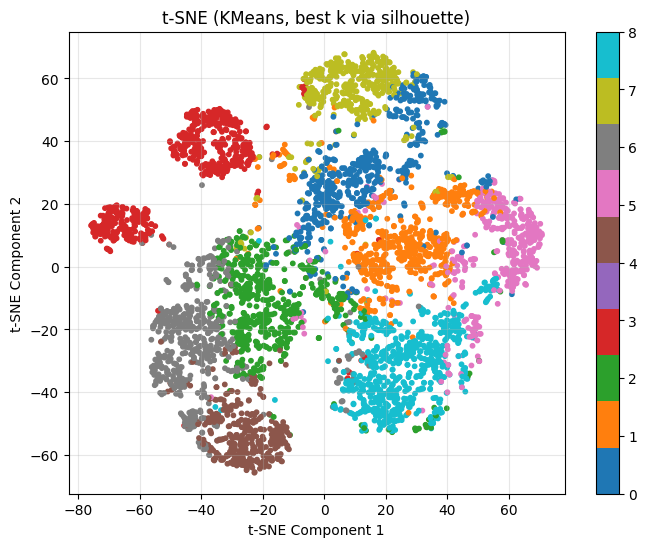

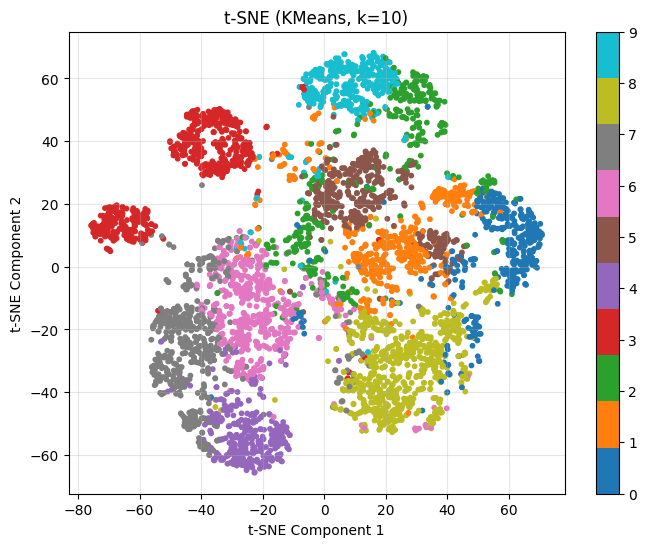


🖼️ Displaying 5 random images from each of 9 clusters:
Cluster 0 (contains 572 images):
Cluster 1 (contains 617 images):
Cluster 2 (contains 628 images):
Cluster 3 (contains 592 images):
Cluster 4 (contains 397 images):
Cluster 5 (contains 443 images):
Cluster 6 (contains 606 images):
Cluster 7 (contains 429 images):
Cluster 8 (contains 716 images):


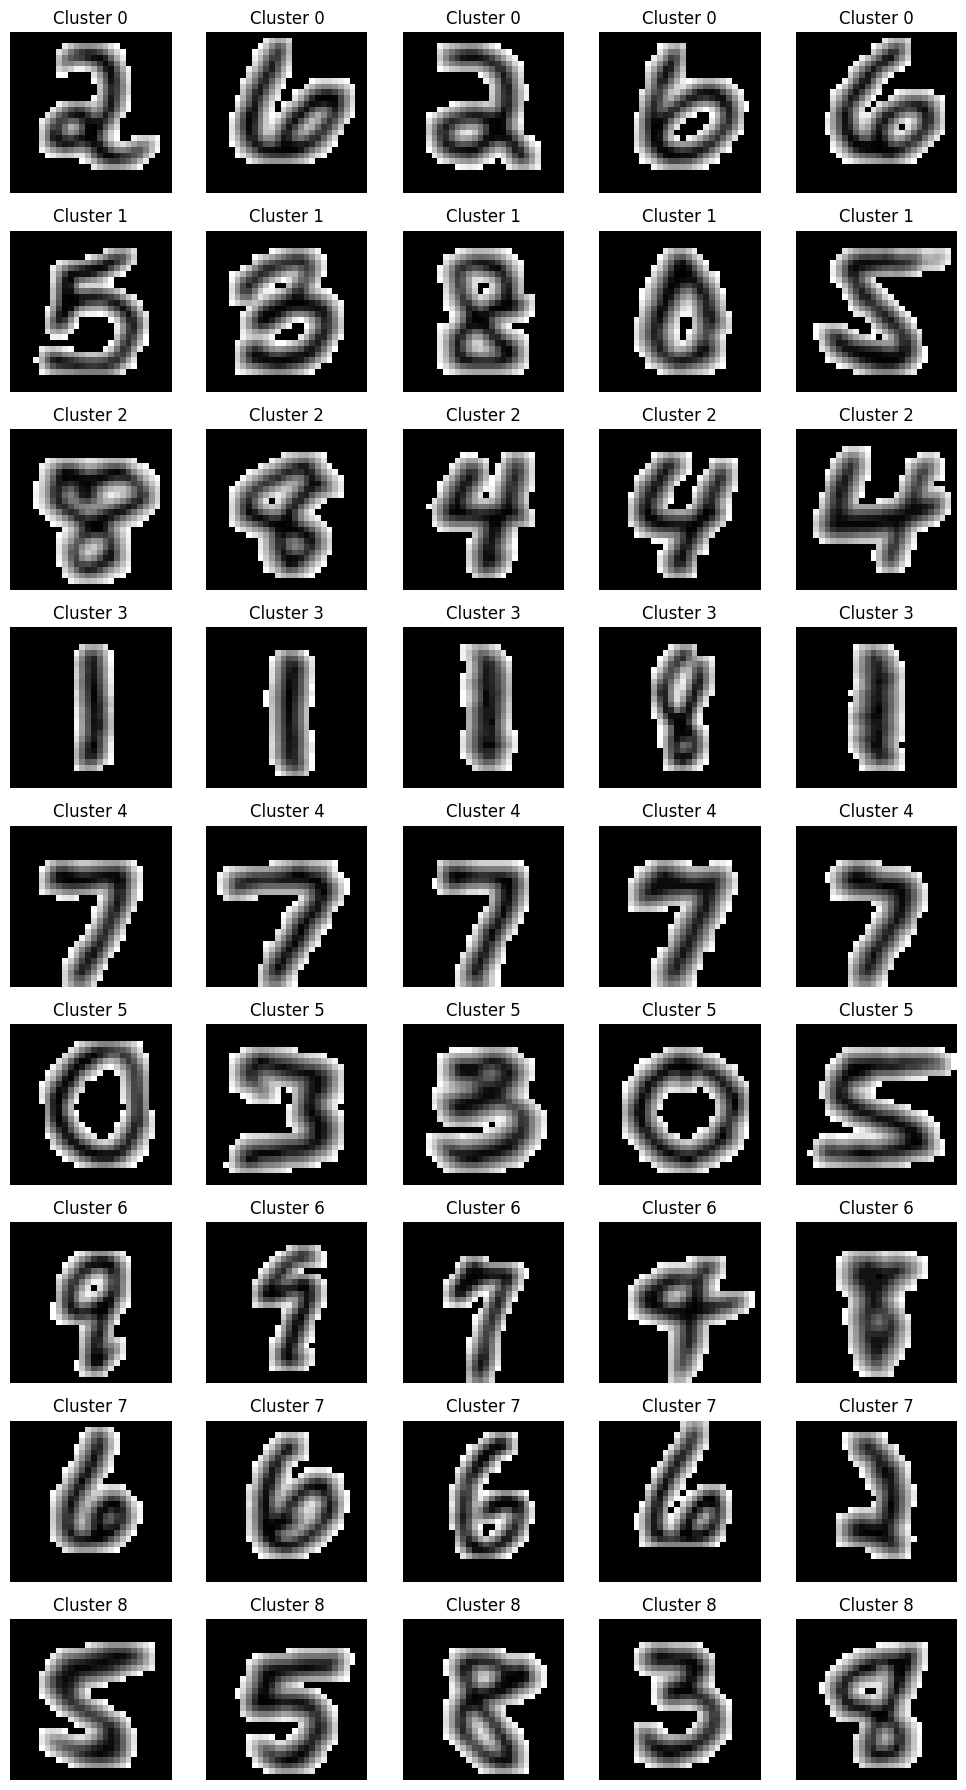


🖼️ Displaying 5 random images from each of 10 clusters:
Cluster 0 (contains 417 images):
Cluster 1 (contains 490 images):
Cluster 2 (contains 431 images):
Cluster 3 (contains 582 images):
Cluster 4 (contains 375 images):
Cluster 5 (contains 449 images):
Cluster 6 (contains 556 images):
Cluster 7 (contains 583 images):
Cluster 8 (contains 730 images):
Cluster 9 (contains 387 images):


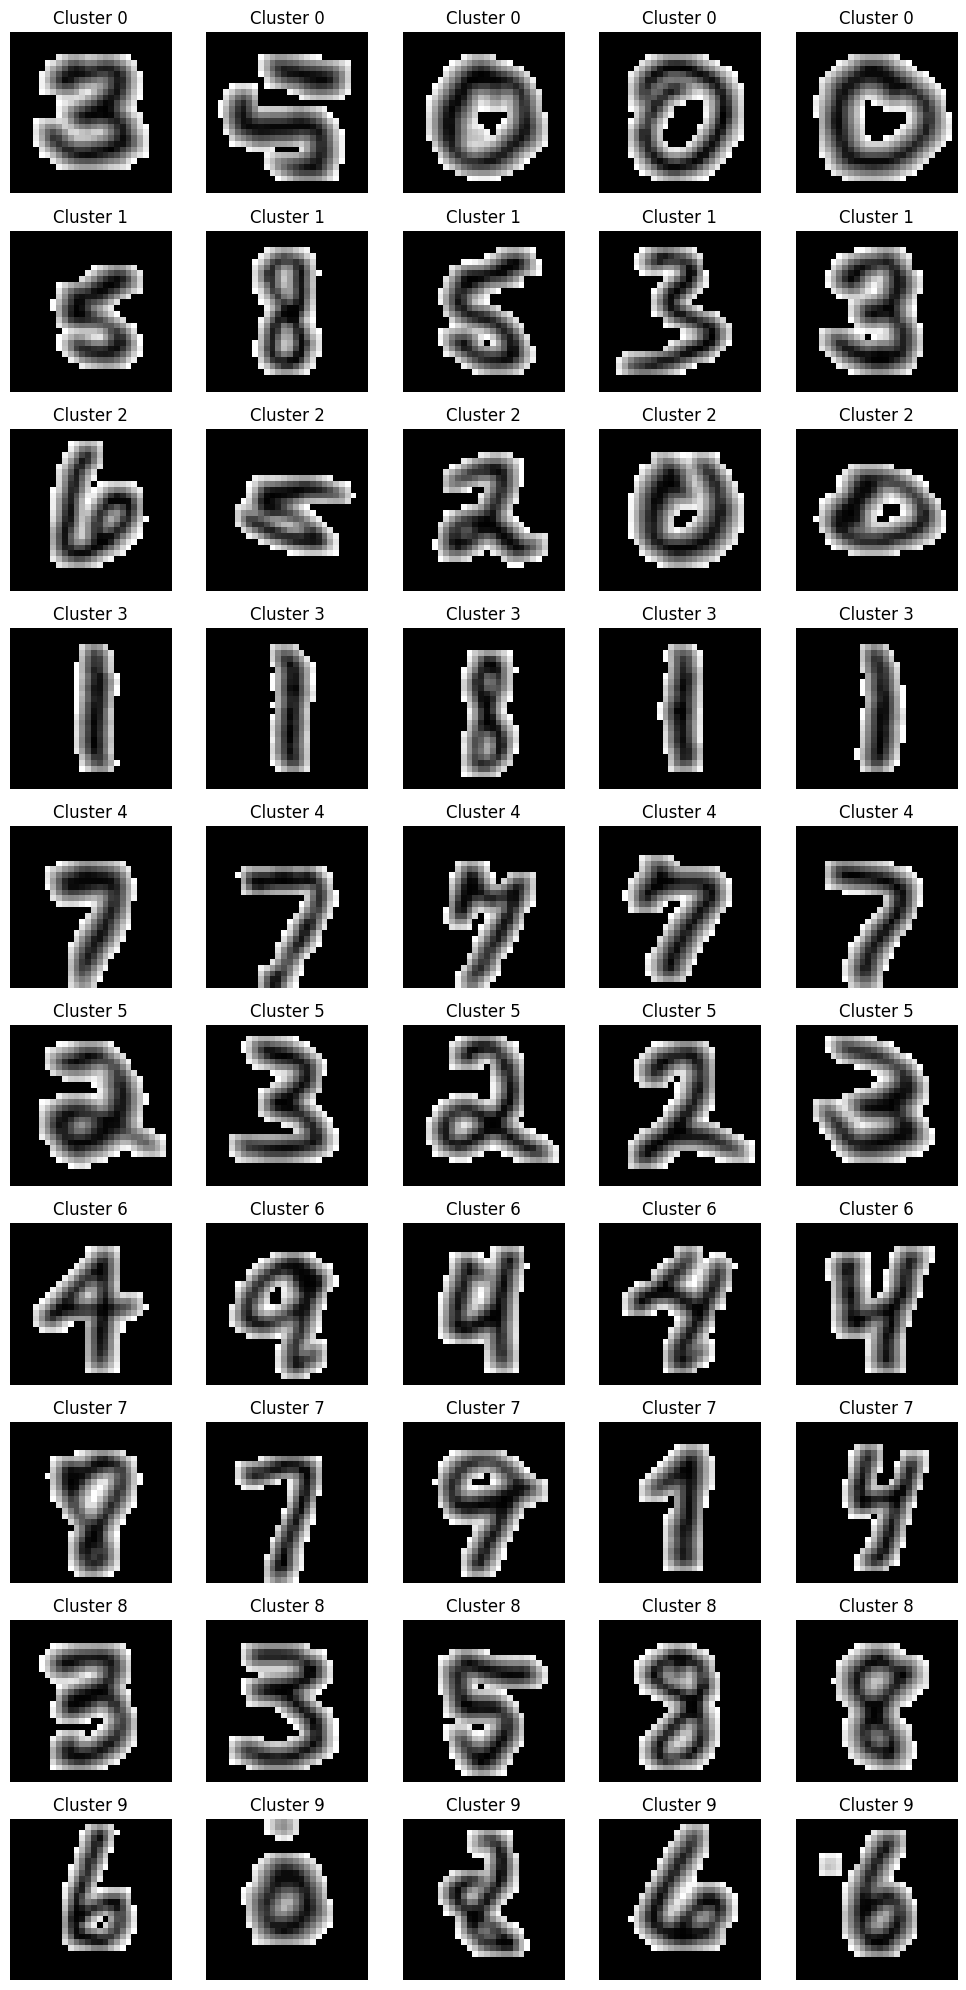

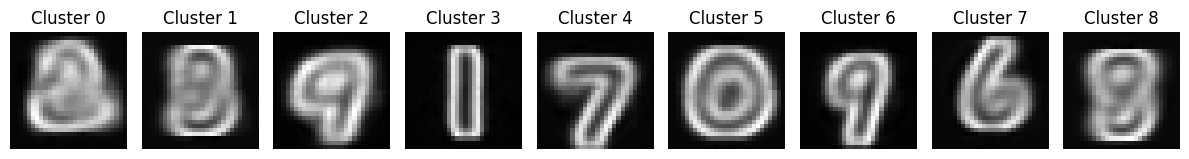

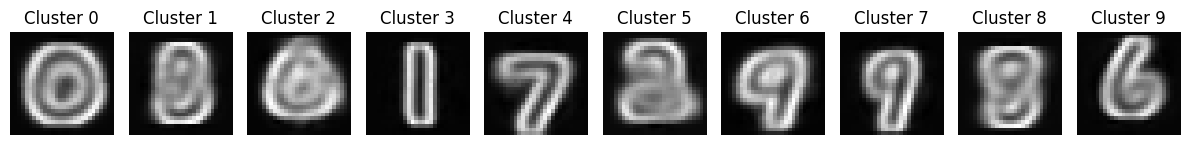

In [314]:
# --- Main Pipeline Execution ---
# Uncomment below lines and provide X to run end-to-end
#X_flat = X.reshape(X.shape[0], -1)
X_pca, pca, X_flat = reduce_dimensionality(X)
print_pca_variance(pca)

y_kmeans, kmeans_model_k10  = apply_kmeans(X_pca, use_silhouette_score=False)
y_kmeans_with_ss, kmeans_model_ss  = apply_kmeans(X_pca, use_silhouette_score=True)

acc_kmeans, y_test_kmeans, y_pred_kmeans = train_and_evaluate(X_flat, y_kmeans)
acc_kmeans_ss, y_test_ss, y_pred_ss = train_and_evaluate(X_flat, y_kmeans_with_ss)

if acc_kmeans is not None:
    print(f"KMeans RF Accuracy (k=10): {acc_kmeans:.4f}")
else:
    print("KMeans RF Accuracy (k=10): N/A")

if acc_kmeans_ss is not None:
    print(f"KMeans RF Accuracy (best k via silhouette): {acc_kmeans_ss:.4f}")
else:
    print("KMeans RF Accuracy (best k via silhouette): N/A")

# Precision, Recall, F1-score
print_precision_recall_f1(y_test_kmeans, y_pred_kmeans, model_name="KMeans (k=10)")
print_precision_recall_f1(y_test_ss, y_pred_ss, model_name="KMeans (best k via silhouette)")

plot_tsne(X_pca, y_kmeans_with_ss, title="t-SNE (KMeans, best k via silhouette)")
plot_tsne(X_pca, y_kmeans, title="t-SNE (KMeans, k=10)")

# --- Visualization of Random Images from Clusters ---
# Use the captured labels from the clustering steps
# Ensure X here is the original image data suitable for display (e.g., (n_samples, 28, 28))
# Based on the earlier code, X was set to dataset[:5000] and had shape (5000, 28, 28).
# plot_random_images_from_clusters expects X to be the original image data, but the internal code uses X_flat[img_index].reshape(28, 28)
# This suggests plot_random_images_from_clusters needs the flattened data used for clustering (X_flat_from_pca in this revised code).
# Let's pass X_flat_from_pca to this function.

plot_random_images_from_clusters(X_pca, y_kmeans_with_ss, num_images_per_cluster=5)
plot_random_images_from_clusters(X_pca, y_kmeans, num_images_per_cluster=5)

# --- Visualize Cluster Centroids ---
# Pass the KMeans model object (kmeans_model_ss or kmeans_model_k10) and the PCA model object (pca)
plot_cluster_centroids(kmeans_model_ss, pca, image_shape=(28, 28)) # Use the model from silhouette score clustering
plot_cluster_centroids(kmeans_model_k10, pca, image_shape=(28, 28)) # Use the model from k=10 clustering